In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random


from numpy import random
from sklearn.preprocessing import OrdinalEncoder
from IPython import display


#tf.compat.v1.disable_eager_execution()

#%matplotlib inline
random.seed(246)

In [2]:
from Preparation import *
df, cols = prep_data()

In [3]:
split_train_ratio = 0.8 #
max_journ_len = 16 #as specified in prep_data.jpynb
# Changeable Hyperparameters
num_epochs = 50
lr = 0.001
batch_size = 20
layer1size = 12
layer2size = 12
loss = 'sparse_categorical_crossentropy'
#'mean_squared_error'
# 'binary_crossentropy'
# 'sparse_categorical_crossentropy' the most useful loss for this task


In [4]:
# Dividing the dataset into test and training data
journeys = df['journey_id'].unique()
num_train_samples = int(len(journeys) * split_train_ratio)
shuffled_journeys = np.random.permutation(journeys)
df_train = df[df['journey_id'].isin(shuffled_journeys[:num_train_samples])]
df_test = df[df['journey_id'].isin(shuffled_journeys[num_train_samples:])]

# Next step: transform to tensor

In [5]:
# Transforming the data to three dimensions according to customer journey
X_test, Y_test = mta2tensor(df_test, max_journ_len)
X_train, Y_train = mta2tensor(df_train, max_journ_len)


In [6]:
# Transforming data into tensor and batches
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

In [7]:
print('Size training data : ', len(X_train), '\nSize test data: ', len(X_test))

Size training data :  1360 
Size test data:  340


In [8]:
# Defining some needed input values
time_steps = max_journ_len
input_dim = df_train.shape[1] - 2  # -2 weil journey_id und transaction wegfällt
num_classes = 2 # 1 for binary_loss and mse, 2 for sparse_categorical

# The Models

In [9]:
#from tensorflow import keras
from Keras_GRU import *

In [10]:
# to log train and test loss during training
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))

## LSTM network

In [11]:
# LSTM Model for comparison

modelLSTM = tf.keras.Sequential()

modelLSTM.add(
    tf.keras.layers.LSTM(units = layer1size, input_shape=(time_steps, input_dim),
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)
modelLSTM.add(
    tf.keras.layers.LSTM(units = layer2size,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)

modelLSTM.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [12]:
modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

# Create instances of the custom callback
loss_history_LSTM = LossHistory()

# Train the model with the custom callback
modelLSTM.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_LSTM])

Epoch 1/50
68/68 [==============================] - 6s 28ms/step - loss: 0.8327 - accuracy: 0.5985 - val_loss: 0.6141 - val_accuracy: 0.7088
Epoch 2/50
68/68 [==============================] - 1s 13ms/step - loss: 0.6477 - accuracy: 0.7199 - val_loss: 0.5917 - val_accuracy: 0.7441
Epoch 3/50
68/68 [==============================] - 1s 14ms/step - loss: 0.6234 - accuracy: 0.7162 - val_loss: 0.5735 - val_accuracy: 0.7412
Epoch 4/50
68/68 [==============================] - 1s 14ms/step - loss: 0.6019 - accuracy: 0.7228 - val_loss: 0.5664 - val_accuracy: 0.7412
Epoch 5/50
68/68 [==============================] - 1s 14ms/step - loss: 0.5885 - accuracy: 0.7221 - val_loss: 0.5634 - val_accuracy: 0.7412
Epoch 6/50
68/68 [==============================] - 1s 14ms/step - loss: 0.5631 - accuracy: 0.7449 - val_loss: 0.6852 - val_accuracy: 0.6529
Epoch 7/50
68/68 [==============================] - 1s 14ms/step - loss: 0.6469 - accuracy: 0.6743 - val_loss: 0.5557 - val_accuracy: 0.7412
Epoch 8/50
68

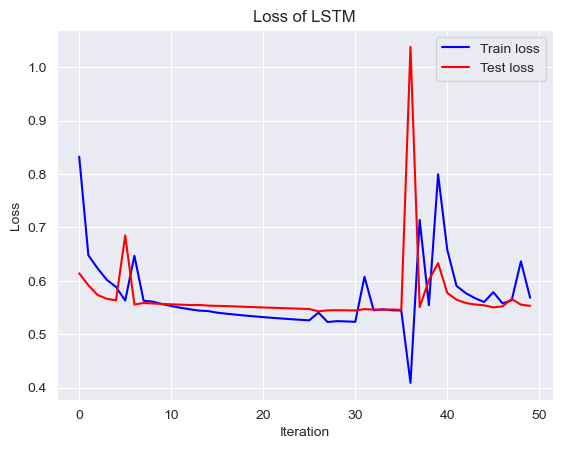

In [13]:
plt.plot(loss_history_LSTM.train_losses, '-b', label='Train loss')
plt.plot(loss_history_LSTM.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of LSTM')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## GRU network
(also uses custom phased GRUCell, but without time gate (time_gate=False))

In [14]:
modelGRU = tf.keras.Sequential()

modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=False),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=False),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [15]:
modelGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_GRU = LossHistory()

# Train the model with the custom callback

modelGRU.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_GRU])

Epoch 1/50
68/68 [==============================] - 7s 33ms/step - loss: 0.8836 - val_loss: 0.6494
Epoch 2/50
68/68 [==============================] - 1s 22ms/step - loss: 0.6579 - val_loss: 0.6088
Epoch 3/50
68/68 [==============================] - 1s 22ms/step - loss: 0.6343 - val_loss: 0.5883
Epoch 4/50
68/68 [==============================] - 2s 22ms/step - loss: 0.6149 - val_loss: 0.5778
Epoch 5/50
68/68 [==============================] - 2s 22ms/step - loss: 0.6039 - val_loss: 0.5724
Epoch 6/50
68/68 [==============================] - 1s 22ms/step - loss: 0.5970 - val_loss: 0.5689
Epoch 7/50
68/68 [==============================] - 2s 23ms/step - loss: 0.5913 - val_loss: 0.5664
Epoch 8/50
68/68 [==============================] - 2s 22ms/step - loss: 0.5867 - val_loss: 0.5645
Epoch 9/50
68/68 [==============================] - 2s 27ms/step - loss: 0.6229 - val_loss: 0.5683
Epoch 10/50
68/68 [==============================] - 2s 23ms/step - loss: 0.5886 - val_loss: 0.5673
Epoch 11/

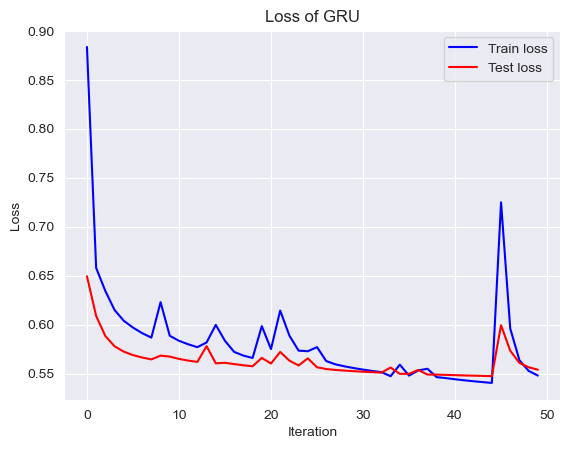

In [16]:
plt.plot(loss_history_GRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## DIY phased GRU

In [17]:
modelphasedGRU = tf.keras.Sequential()

modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=True),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=True, last_layer=True),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelphasedGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [18]:
modelphasedGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_phasedGRU = LossHistory()

# Train the model with the custom callback

modelphasedGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[loss_history_phasedGRU])

Epoch 1/50
68/68 [==============================] - 13s 57ms/step - loss: 0.8506 - val_loss: 0.6600
Epoch 2/50
68/68 [==============================] - 3s 39ms/step - loss: 0.6874 - val_loss: 0.6485
Epoch 3/50
68/68 [==============================] - 3s 41ms/step - loss: 0.6789 - val_loss: 0.6355
Epoch 4/50
68/68 [==============================] - 3s 40ms/step - loss: 0.6616 - val_loss: 0.6161
Epoch 5/50
68/68 [==============================] - 3s 40ms/step - loss: 0.6386 - val_loss: 0.5936
Epoch 6/50
68/68 [==============================] - 3s 39ms/step - loss: 0.6156 - val_loss: 0.5786
Epoch 7/50
68/68 [==============================] - 3s 39ms/step - loss: 0.5977 - val_loss: 0.5711
Epoch 8/50
68/68 [==============================] - 3s 40ms/step - loss: 0.5814 - val_loss: 0.5667
Epoch 9/50
68/68 [==============================] - 3s 40ms/step - loss: 0.5664 - val_loss: 0.5640
Epoch 10/50
68/68 [==============================] - 3s 41ms/step - loss: 0.5537 - val_loss: 0.5621
Epoch 11

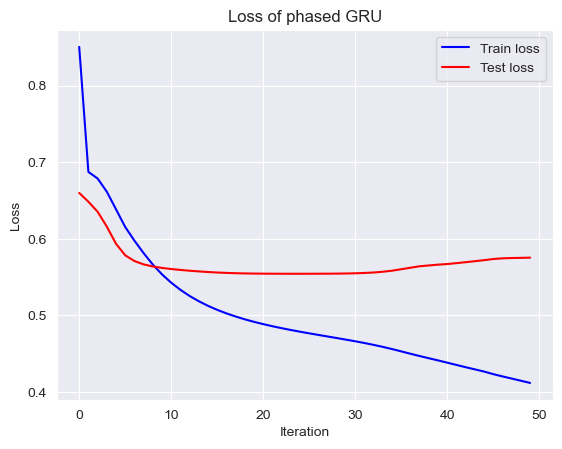

In [19]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of phased GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Comparison of models

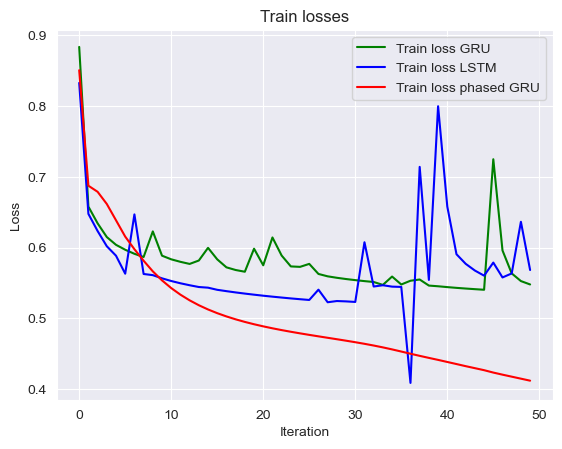

In [20]:
plt.plot(loss_history_GRU.train_losses, '-g', label='Train loss GRU')
plt.plot(loss_history_LSTM.train_losses, '-b', label='Train loss LSTM')
plt.plot(loss_history_phasedGRU.train_losses, '-r', label='Train loss phased GRU')
plt.legend(loc=0)
plt.title('Train losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('TrainingLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))
plt.show()

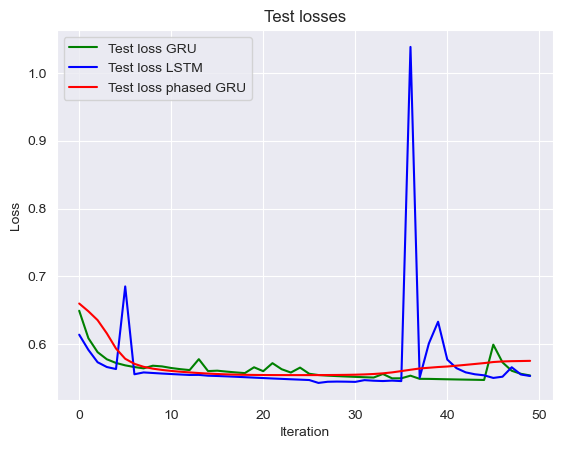

In [21]:
plt.plot(loss_history_GRU.test_losses, '-g', label='Test loss GRU')
plt.plot(loss_history_LSTM.test_losses, '-b', label='Test loss LSTM')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss phased GRU')
plt.legend(loc=0)
plt.title('Test losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('TestLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))
plt.show()

In [22]:
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 16, 12)            4752      
                                                                 
 rnn_1 (RNN)                 (None, 12)                936       
                                                                 
 dense_1 (Dense)             (None, 2)                 26        
                                                                 
Total params: 5,714
Trainable params: 5,714
Non-trainable params: 0
_________________________________________________________________


In [23]:
modelphasedGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_2 (RNN)                 (None, 16, 12)            4746      
                                                                 
 rnn_3 (RNN)                 (None, 12)                930       
                                                                 
 dense_2 (Dense)             (None, 2)                 26        
                                                                 
Total params: 5,702
Trainable params: 5,702
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 12)            6288      
                                                                 
 lstm_1 (LSTM)               (None, 12)                1200      
                                                                 
 dense (Dense)               (None, 2)                 26        
                                                                 
Total params: 7,514
Trainable params: 7,514
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Save optimized model after Hyperparametertuning
'''
modelGRU.save('GRUmodel')
modelphasedGRU.save('phasedGRUmodel')

cols = cols.drop(['timestamp','transaction','journey_id'])
text_file = open('cols.txt', 'w')
for i in cols:
    text_file.write(i + '\n')
text_file.close()
#reloaded_modelGRU = tf.keras.models.load_model('GRUmodel')
#reloaded_modelphasedGRU = tf.keras.models.load_model('phasedGRUmodel')
'''

"\nmodelGRU.save('GRUmodel')\nmodelphasedGRU.save('phasedGRUmodel')\n\ncols = cols.drop(['timestamp','transaction','journey_id'])\ntext_file = open('cols.txt', 'w')\nfor i in cols:\n    text_file.write(i + '\n')\ntext_file.close()\n#reloaded_modelGRU = tf.keras.models.load_model('GRUmodel')\n#reloaded_modelphasedGRU = tf.keras.models.load_model('phasedGRUmodel')\n"

In [26]:
# evaluate accuracy??
modelLSTM.evaluate(test_dataset)
modelGRU.evaluate(test_dataset)
modelphasedGRU.evaluate(test_dataset)

17/17 [==============================] - 0s 11ms/step - loss: 0.5755


0.5755020380020142

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


In [28]:
#all based on sparse_categorical_crossentropy loss and two classes
y_pred_lstm = modelLSTM.predict(X_test)
y_pred_gru = modelGRU.predict(X_test)
y_pred_phasedgru = modelphasedGRU.predict(X_test)

11/11 [==============================] - 1s 9ms/step


In [29]:
auc_lstm = roc_auc_score(Y_test, y_pred_lstm[:,-1])
auc_gru = roc_auc_score(Y_test, y_pred_gru[:,-1])
auc_phasedgru = roc_auc_score(Y_test, y_pred_phasedgru[:,-1])
print('AUC for LSTM: {}\nAUC for GRU: {}\nAUC for phased_GRU: {}'.format(auc_lstm,auc_gru,auc_phasedgru))

AUC for LSTM: 0.776872353976996
AUC for GRU: 0.7766288261960961
AUC for phased_GRU: 0.7858641489640704


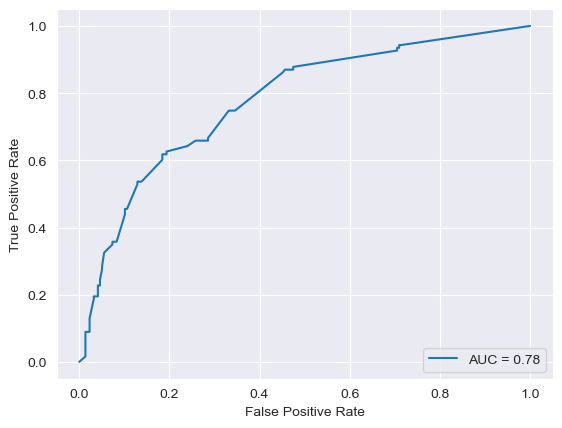

In [30]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_lstm[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lstm)
#plt.title('ROC of LSTM')
plt.plot()

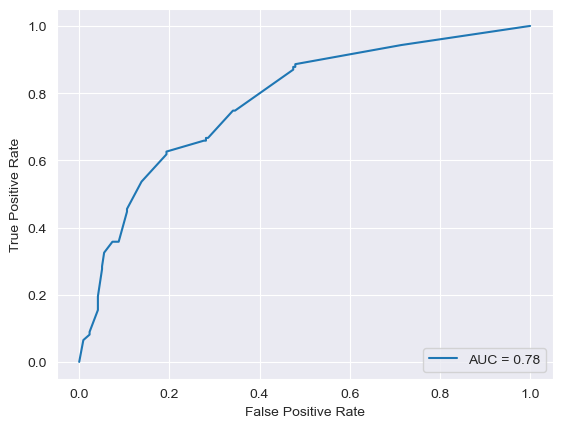

In [31]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_gru[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_gru)
#plt.title('ROC of GRU')
plt.plot()

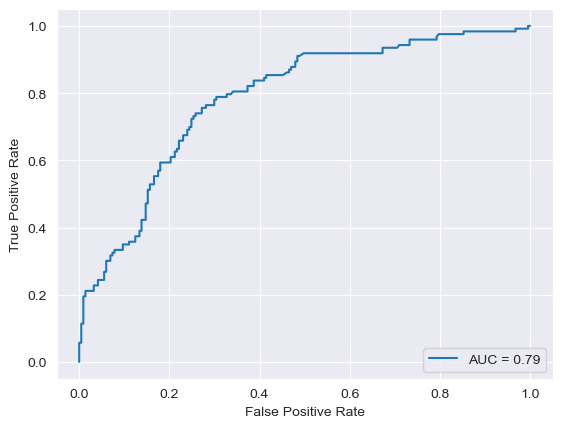

In [32]:
fpr, tpr, _  = roc_curve(Y_test, y_pred_phasedgru[:,-1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_phasedgru)
#plt.title('ROC of phasedGRU')
plt.plot()

# Explanations


In [33]:
y_pred_phasedgru[:,1]

array([0.40673614, 0.07211926, 0.21241547, 0.07908389, 0.04760199,
       0.1374307 , 0.0551871 , 0.05273717, 0.09260146, 0.21777467,
       0.9026092 , 0.03289214, 0.0343974 , 0.06206043, 0.4359439 ,
       0.06487714, 0.27105096, 0.3938592 , 0.09455977, 0.14000173,
       0.68521285, 0.0550405 , 0.10364404, 0.72558475, 0.9066489 ,
       0.76398736, 0.06398362, 0.12843168, 0.60824156, 0.5818083 ,
       0.67173296, 0.0340956 , 0.26004207, 0.3830125 , 0.3470674 ,
       0.09260146, 0.40102863, 0.8515802 , 0.31481692, 0.05839532,
       0.0453366 , 0.8335642 , 0.08382288, 0.7053778 , 0.8771188 ,
       0.12910922, 0.06610116, 0.8438356 , 0.04114087, 0.03315281,
       0.07647377, 0.8290689 , 0.775442  , 0.13612288, 0.07647377,
       0.15851484, 0.17219776, 0.23349108, 0.04647498, 0.66158336,
       0.31078622, 0.37543073, 0.78851175, 0.0550405 , 0.04380379,
       0.44958934, 0.84443927, 0.07211926, 0.9153184 , 0.78799576,
       0.10983235, 0.34858468, 0.6620574 , 0.03267863, 0.55720

In [34]:
# is prediction 1?
print('expected outcome test: ', sum(Y_test)/len(Y_test), '\nexpected outcome train: ',sum(Y_train)/len(Y_train))

expected outcome test:  0.36176470588235293 
expected outcome train:  0.35441176470588237


# Shapleyvalues

In [35]:
import shap
#from keras import utils
#from sklearn.preprocessing import StandardScaler
#from sklearn.neural_network import MLPRegressor
#from sklearn.pipeline import make_pipeline

#from sklearn.datasets import load_diabetes
#from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [36]:
#keras.utils.plot_model(modelLSTM, "my_first_model_with_shape_info.png")

In [37]:
# data as tensors unbatched/sliced
x_train = np.array(X_train)
x_test = np.array(X_test)

In [38]:
x_test[0:3].shape

(3, 16, 118)

In [39]:
explainer = shap.DeepExplainer(modelLSTM, x_train[:20])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [40]:
tf.__version__

'2.10.0'

In [41]:
explainer

In [42]:
shap_values = explainer.shap_values(x_test[:20])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 254, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 385, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefix before the lookup
    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 681, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "C:\Users\leoni\anaconda3\envs\gru\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 231, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer "lstm" "                 f"(type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer "lstm" "                 f"(type LSTM):
      • inputs=tf.Tensor(shape=(40, 16, 118), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [ ]:
shap.initjs()
shap.force_plot(explainer, shap_values)

In [ ]:
explainer = shap.Explainer(modelLSTM)

# Prepare a sample input data point (sequence) for explanation
#sample_input = np.array([[...]])  # Replace with your input data

# Calculate Shapley values for the sample input
shap_values = explainer(, max_evals=4000)

# Print or visualize the SHAP values to interpret the model's output
shap.summary_plot(shap_values)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test[0:3])

In [ ]:
#shap.summary_plot(shap_values,x_test)
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:]  ,x_test[0,:])